In [1]:
import os
import re
import json
import pandas as pd

In [2]:
pd.set_option('display.max_colwidth', -1) # This will set the no truncate for Pandas as well as for Dask. I am not sure how it does for Dask though, but it works.

/tmp/ipykernel_6875/220492459.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) # This will set the no truncate for Pandas as well as for Dask. I am not sure how it does for Dask though, but it works.


# 0. Data Load

In [3]:
with open('all.json') as f:
    all_data = json.loads(f.read())

In [4]:
all_data_df = pd.DataFrame.from_dict(all_data)

In [5]:
all_data_df.tail(50)

,title,text,tags,date,subcategory,category
314899,"Șapte zile, plus una - lansare de carte","Muzeul Național al Literaturii române propune o întâlnire cu Mircea Mihăieș și Ilie Stepan pe 18 noiembrie 2018, la ora 18.00, la Muzeul Național al Literaturii Române (Strada Nicolae Crețulescu 8) pentru a lansa și dezbate împreună cartea unui dialog inedit, o retrospectivă ce așază cititorul într-un orizont de așteptare complex în care se developează imagini ale copilăriei, ale rezistenței prin muzică, în care se inserează subtil importanța valorilor, a demnității și prezenței artistului pe scenă și în afara ei.\n„Șapte zile, plus una. Mircea Mihăieș în dialog cu Ilie Stepan (Editura Polirom, 2018)” va fi lansată pe 14 și pe 21 noiembrie, la Timișoara, la Librăria La Două Bufnițe și, respectiv, la Aula Magna a Universității de Vest, iar pe 17 noiembrie, la Târgul de carte Gaudeamus.\nDespre autori\nMircea Mihăieș (n. 1 ianuarie 1954) este profesor de literatură engleză și americană la Universitatea de Vest din Timișoara. Între 2005 și 2012 a fost vicepreședinte al Institutului Cultural Român. Redactor-șef al revistei Orizont. Volume publicate: De veghe în oglindă (1989); Cartea eșecurilor. Eseu despre rescriere (1990); Femeia în roșu (1990, în colaborare cu Adriana Babeți și Mircea Nedelciu); Cărțile crude. Jurnalul intim și sinuciderea (1995); Victorian Fiction (1998); Masca de fiere (2000); Atlanticul imaginar (2002); Scutul lui Perseu (2003); Viața, patimile și cântecele lui Leonard Cohen (2005); Metafizica detectivului Marlowe (2008, tradus în Statele Unite în 2014); Despre doliu. Un an din viața lui Leon W. (2009); Ultimul Judt (2011); Ce rămâne. William Faulkner și misterele ținutului Yoknapatawpha (2012); Istoria lui Corto Maltese, pirat, anarhist și visător (2014); Ulysses, 732. Romanul romanului (2016). A publicat șase volume în colaborare cu Vladimir Tismăneanu. Lucrează la o biografie ficțională a personajului Molly Bloom.\nIlie Stepan (n. 24 noiembrie 1953), compozitor, ghitarist, instrumentist (vioară, pian, blockflöte, percuție, midi-programming), inginer de sunet, orchestrator, autor și producător de proiecte muzicale. Membru fondator și lider al grupurilor PRO Musica, Stepan Project, Stepan Project Blues Foundation. Inițiator, împreună cu Horea Crișovan, al proiectului de ghitară acustică „Anotimpurile ghitării”. A compus muzică pentru peste 100 de spectacole de teatru și peste 50 de filme documentare și de televiziune.","[ilie stepan, intalnire, lansare, lansare carte, mircea mihaies, muzeul national al literaturii, plus una- mircea mihaies in dialog cu ilie stepan, sapte zile, sapte zile plus una]",02 noi 2018 / 09:17,"[Cultura, Carte]",Cultura
314900,Ceremonia de acordare a premiilor Oscar va fi transmisă din mai multe locuri,"Ceremonia de acordare a premiilor Oscar de pe 25 aprilie va fi transmisă din mai multe locuri, a anunțat un purtător de cuvânt al Academiei americane de film, scrie ABC News.\nOrganizatorii vor respecta tradiția și Dolby Theatre din Hollywood va găzdui Gala Oscar, dar de data aceasta ceremonia va fi transmisă Live din mai multe locuri.\nPurtătorul de cuvânt a precizat că Academia este „hotărâtă să prezinte o gală Oscar ca nicio alta, în timp ce va prioritiza sănătatea publică și siguranța tuturor celor care vor participa.”\nÎntre timp, centre cinematografice precum Los Angeles, New York și Londra se află încă sub restricții.\nAmintim că ceremonia de acordare a premiilor Oscar a fost amânată cu aproximativ două luni, din cauza pandemiei.","[ceremonie, gala, hollywood, live, premiile oscar]",11 feb 2021 / 08:50,"[Cultura, Film]",Cultura
314901,"Mitică Popescu, de Camil Petrescu, premieră la Nottara","Reprezentația va avea loc vineri, 30 noiembrie, de la ora 19.00, la Sala Horia Lovinescu. Din distribuție fac parte: Dan Tudor, Ada Navrot, Dani Popescu, Cristian Nicolaie, Raluca Tița, Daniela Minoiu, Ion Haiduc, Andreea Măcelaru Șofron, Mihai Marinescu, Mircea Teodorescu. Scenografia este semnată

In [6]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314949 entries, 0 to 314948
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        314949 non-null  object
 1   text         314949 non-null  object
 2   tags         314949 non-null  object
 3   date         314949 non-null  object
 4   subcategory  314949 non-null  object
 5   category     314949 non-null  object
dtypes: object(6)
memory usage: 14.4+ MB


# 1. EDA

## 1.1. Categories

In [7]:
set(all_data_df.category)

{'Coronavirus',
 'Cultura',
 'Economie',
 'Lifestyle',
 'Politica',
 'Sanatate',
 'Sport',
 'Stiri',
 'Tehnologie'}

In [8]:
all_data_df.groupby(['category']).count().sort_values(ascending=False, by='title')

,title,text,tags,date,subcategory
category,,,,,
Stiri,154201,154201,154201,154201,154201
Politica,63746,63746,63746,63746,63746
Lifestyle,28522,28522,28522,28522,28522
Sport,24392,24392,24392,24392,24392
Economie,17542,17542,17542,17542,17542
Sanatate,11433,11433,11433,11433,11433
Cultura,8004,8004,8004,8004,8004
Coronavirus,5607,5607,5607,5607,5607
Tehnologie,1502,1502,1502,1502,1502


<AxesSubplot:xlabel='category'>

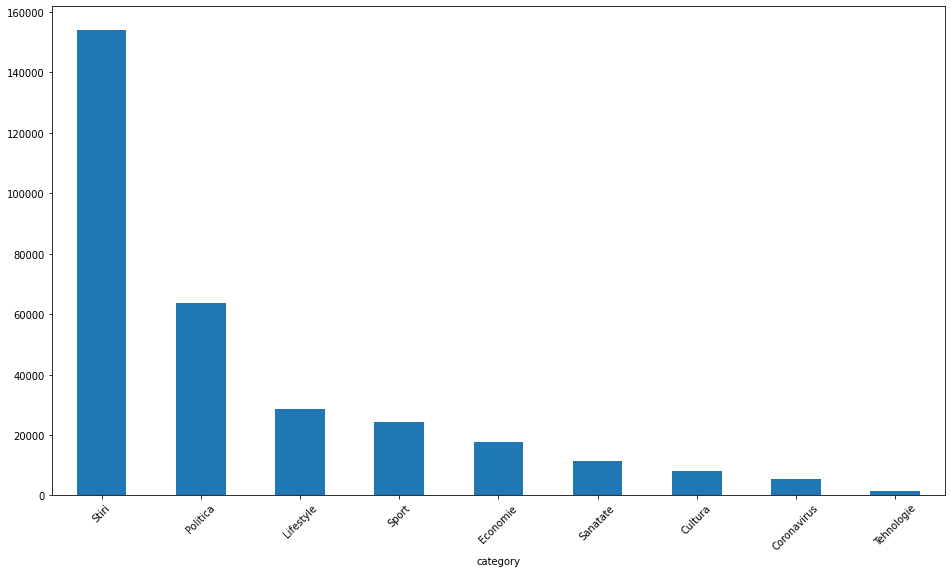

In [9]:
all_data_df.groupby(['category']).count().sort_values(ascending=False, by='title')['title'].plot(kind='bar', rot='45', figsize=(16,9))

## 1.2. Subcategories

In [10]:
# all_data_df.groupby(all_data_df['subcategory'].map(tuple))['title'].sum()

<AxesSubplot:xlabel='subcategory'>

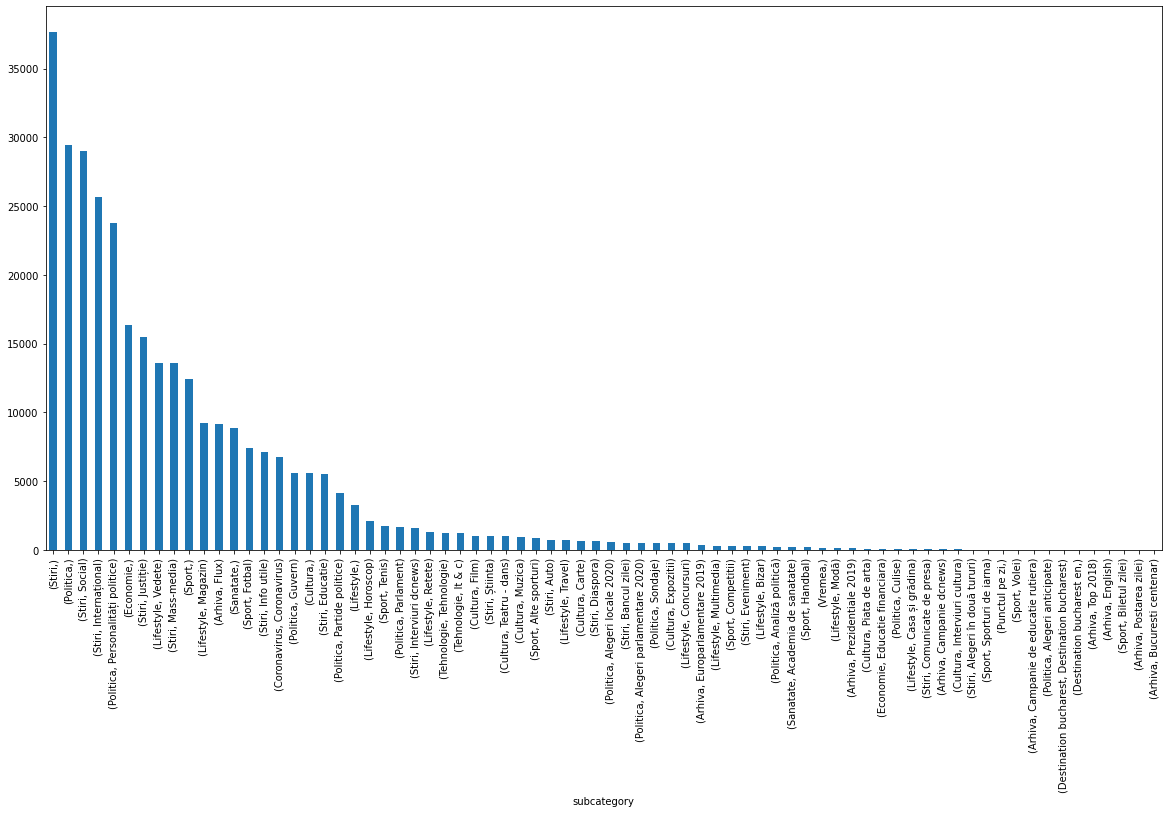

In [11]:
all_data_df.groupby(all_data_df['subcategory'].map(tuple))['title'].count().sort_values(ascending=False).plot(kind='bar', rot='90', figsize=(20,10))

# 2. Preprocessing

In [12]:
all_data_df.set_index('title').filter(regex='china', axis=0).count()

text           59
tags           59
date           59
subcategory    59
category       59
dtype: int64

In [13]:
clickbait_expression1 = 'incredibil|excep[t|ț]ional|remarcabil|record|uria[ș|s]|lovitur[a|ă]|șoc|avertiza|tulbur'
clickbait_expression2 = 'BIZARĂ|LOVITURA|REMARCABIL|URIAȘ|IEFTIN|EXTRA|INCREDIBIL|RECORD|ACCEPTĂ|GRATIS|ABONAMENT|PRIMA|ISTORIC|DĂ|ONLINE|ȘOC|DOLIU|EXCEPȚIONAL|AVERTIZA|TULBUR|MARE|MAJOR|SCHIMB|ÎNCHID|UNIC|APEL|SCHIMBAT|DEZVĂL|PĂCĂL|NU|SPARGE|DEMISION|SPION|PERICOL|RĂZBOI|DECIZIE|REVOLUȚI|ELECTRONIC|POZ|AN|BIZAR|CORPORAT|REMARCABIL|SCUMP'

In [14]:
all_data_df[all_data_df['title'].str.contains(clickbait_expression1,
                                              flags=re.IGNORECASE, case=False, regex=True)==True].count()

title          9069
text           9069
tags           9069
date           9069
subcategory    9069
category       9069
dtype: int64

In [15]:
all_data_df[all_data_df['title'].str.contains(clickbait_expression2,
                                              flags=re.IGNORECASE, case=True, regex=True)==True].count()

title          215648
text           215648
tags           215648
date           215648
subcategory    215648
category       215648
dtype: int64

In [16]:
data_clickbait1 = all_data_df[all_data_df['title'].str.contains(clickbait_expression1,
                                                                flags=re.IGNORECASE, case=False, regex=True)==True]
data_clickbait2 = all_data_df[all_data_df['title'].str.contains(clickbait_expression2, case=True, regex=True)==True]

In [17]:
# data_clickbait = pandas.concat([data_clickbait1,data_clickbait2]).drop_duplicates().reset_index(drop=True)

In [18]:
# data_clickbait.title.head(10)

In [19]:
# pd.concat([data_clickbait1,data_clickbait2]).drop_duplicates().reset_index(drop=True)

In [20]:
data_clickbait1.head(25)

,title,text,tags,date,subcategory,category
72,Lovitură pentru utilizatorii TikTok. Va ieși de pe piață,"TikTok a spus că va renunța la piața din Hong Kong după ce China va impune o nouă lege de securitate asupra orașului.\n""Având în vedere evenimentele recente, am decis să oprim operațiunile aplicației TikTok din Hong Kong"", a declarat un purtător de cuvânt pentru BBC.\nIeșirea companiei din oraș va veni „în câteva zile”, potrivit agenției de știri Reuters.\nDe asemenea, Facebook și Twitter au declarat săptămâna aceasta că „întrerup” cooperarea cu poliția din Hong Kong pentru informațiile utilizatorilor.","[aplicatie, china, hong kong, international, it, tehnologie, tiktok]",07 iul 2020 / 08:31,"[Tehnologie, Tehnologie]",Tehnologie
104,Huawei a dat LOVITURA. Au ajuns la 700 de milioane de utilizatori,"Huawei Mobile Services Ecosystem a înregistrat o creștere de 32% a numărului de utilizatori de la an la an, potrivit Agerpres. Compania are acum 700 de milioane de utilizatori de dispozitive la nivel mondial. A crescut și numărul dezvoltatorilor Huawei înregistrați la nivel mondial ajungând la 1,6 milioane.""AppGallery, platforma oficială de distribuție a aplicațiilor Huawei, acoperă peste 170 de țări și regiuni. Cu această acoperire, sperăm să împărtășim inovația digitală locală cu lumea. Dorim ca fiecare aplicație inovatoare dezvoltată de partenerii globali să ajungă la toți cei 700 de milioane de utilizatori de dispozitive Huawei"", a declarat Zhang Ping'an, președintele Serviciului Cloud pentru Consumatori, Huawei Consumer Business Group.\nHuawei a anunțat anterior un program un miliard de dolari pentru a stimula dezvoltatorii la nivel mondial. Mai mult de 10.000 de aplicații inovatoare au beneficiat de acesta până în prezent. În total, AppGallery conține peste 770 de aplicații românești și zeci de mii de aplicații internaționale. Produsele și serviciile Huawei deservesc mai mult de o treime din populația lumii.","[appgallery, economie, huawei, telefoane]",21 aug 2020 / 15:49,"[Tehnologie, Tehnologie]",Tehnologie
130,"Whatsapp, Facebook şi Instagram, RECORDURI de Revelion","Peste 1,4 miliarde de apeluri au fost realizate cu WhatsApp, în întreaga lume, de Revelion, în tip ce Facebook a anunțat că în aceeași zi au fost realizate peste 55 de milioane de transmisiuni live pe Instagram și Facebook.\nPentru Whatsapp, cifra reprezintă o creștere cu peste 50% față de anul anterior\nSpre deosebire de clasicele probleme cu rețelele operatorilor din noaptea de Revelion, serverele Facebook au făcut față fluxului mare de apeluri și nu au împiedicat oamenii să comunice, scrie Adevărul.","[apeluri, facebook, instagram, record, video, whatsapp]",04 ian 2021 / 10:09,"[Tehnologie, Tehnologie]",Tehnologie
155,Google DĂ LOVITURA cu noul său dispozitiv. Smart TV la doar 50 de dolari,"Conform The Verge, 9to5Google a descoperit noul dispozitiv printr-o scurgere de informații de pe Home Depot. „Sabrina” costă 49.99 dolari și ar urma să fie lansat în această toamnă, odată cu telefoanele Pixel 5 și 4a 5G, și ele amânate la rândul lor.\nFață de Chromecast, tot de la Google, utilizatorii nu vor mai fi nevoiți să folosească smartphone-ul pentru a controla ce se întâmplă pe televizor. Acesta va veni cu o telecomandă și va avea un sistem de operare Android.","[android, google, sabrina, smart tv, tehnologie, televizor]",01 sep 2020 / 16:11,"[Tehnologie, Tehnologie]",Tehnologie
158,LOVITURĂ pentru PS5. Ce poate să facă noul Xbox Series X,"Microsoft plănuiește să adauge suport automat HDR pentru jocurile de pe noua sa consolă Xbox Series X, conform The Verge. În timp ce titlurile deja existente vor merge mai bine pe următoarea consolă, Microsoft vrea să adauge și suport HDR pentru a mări și mai mult fidelitatea grafică. Pe lângă acest lucru, unele jocuri ar putea rula de la 30 cadre pe secundă la 60 sau chiar 120 de cadre pe secundă.\n„Într-un parteneriat cu Xbox Advanced Technology Group, Xbox Series X va oferi o tehnică de reconstrucție HDR nouă și inovat

In [21]:
data_clickbait2.head()

,title,text,tags,date,subcategory,category
0,Aplicaţia de telefon cu care poţi face POZE 3D,"Aplicația se numește LucidPix și a fost până acum disponibilă doar în versiunea beta, conform theverge.com.\nIndiferent dacă ai un telefon nou, precum Iphone 11, Samsung ZFlip sau unul mai vechi, precum iPhone 6S, aplicația funcționează. Și nici nu e nevoie de vreo cameră suplimentară. Pentru că aplicația folosește inteligență artificală pentru a randa pozele 3D.","[android, iphone, poze 3d, telefon]",17 iun 2020 / 16:07,"[Tehnologie, Tehnologie]",Tehnologie
2,"Acasă la cel mai MARE jucător de sporturi ELECTRONICE. Cum trăiște Johan ""N0tail"" Sundstein / VIDEO","Într-o postare pe Instagram, BBC a postat imagini de la casa lui Johan ""N0tail"" Sundstein, cel mai mare jucător de sporturi electronice:\n„Johan ""N0tail"" Sundstein este cel mai bine cotat ucător de sporturi electronice din lume, având până acum premii în valoare de peste 7,4 milioane de dolari (5,4 milioane de lire sterline). Am fost invitați să-l vizităm pe Johan la noul său conac cu 17 dormitoare din Lisabona, pentru a vedea cum el și echipa sa s-au adaptat, de la distanță, la antrenamente și la concursuri la turnee cu mize mari. El a vorbit despre impactul jocurilor asupra sănătății sale mintale.“","[casa, electronice, jocuri, johan sundstein, n0tail, portugalia, sporturi]",17 ian 2021 / 15:13,"[Stiri, Internațional]",Tehnologie
4,"Wikipedia, SCHIMBARE după 10 ani! La ce să se aștepte utilizatorii","Conform The Verge, versiunea de desktop a site-ului va fi modificată pentru a permite internauților să o navigheze mai ușor. În topul preferințelor se află noul cuprins, care ajută atunci când căutăm rapid o secțiune dintr-o intrare pe Wikipedia. Mai apoi, bara din partea stânga va putea dispărea pentru a permite concentrarea asupra informațiilor, iar limba paginilor va putea fi schimbată cu un singur click.\nCompania mamă a site-ului, Wikimedia Foundation, a anunțat într-o postare de blog că aceste schimbări vor avea loc „incremental de-a lungul unei perioade lungi de timp”, permițând utilizatorilor să testeze caracteristicile înainte să fie oficiale.","[international, site, tehnologie, wikipedia]",24 sep 2020 / 08:16,"[Tehnologie, Tehnologie]",Tehnologie
5,Schimbări MAJORE pentru Google Hărți. Noi culori prezente,"Conform The Verge, Google a anunțat că hărțile vor fi disponibile în 220 de țări și teritorii, „de la cele mai mari zone metropolitane până la orășelele mici, rurale”. Compania transmite că și hărțile stradale vor primi o actualizare mai detaliată în anumite orașe.\nGoogle a transmis că a folosit imaginile din satelit drept bază pentru reconceperea hărților și că acestea beneficiază de o nouă „tehnică algoritmică de colorare”. Rezultatul diferențiază cu ușurință între peisaje, adică o plajă nu va mai semăna cu un vârf de munte, iar un deșert nu va mai putea fi confundat cu terenuri acoperite de zăpadă”.","[google maps, harti, international, tehnologie]",18 aug 2020 / 21:29,"[Tehnologie, Tehnologie]",Tehnologie
7,O mare companie își ÎNCHIDE magazinele din toată lumea. Motivul deciziei,"New York City (SUA), Londra (Marea Britanie), Sydney (Australia) și Redmond Campus (SUA) vor fi singurele magazine Microsoft care vor mai rămâne deschise. Toate locațiile de vânzare Microsoft au fost închise la nivel global, din cauza pandemiei, iar compania nu le va mai deschide deloc, conform The Verge.\nMicrosoft Store a fost un concept care a debutat în 2009, dorind să urmeze succesul pe care l-a avut Apple cu magazinele sale fizice. La mai bine de 10 ani, Microsoft a decis astfel că modelul de business nu aduce plusvaloare.","[international, microsoft store, tehnologie]",26 iun 2020 / 16:33,"[Tehnologie, Tehnologie]",Tehnologie


In [22]:
data_clickbait2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18204 entries, 0 to 314925
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18204 non-null  object
 1   text         18204 non-null  object
 2   tags         18204 non-null  object
 3   date         18204 non-null  object
 4   subcategory  18204 non-null  object
 5   category     18204 non-null  object
dtypes: object(6)
memory usage: 995.5+ KB


# 2. TF-IDF + SVD + Cosine

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [1]:
# code inspired from: https://stackoverflow.com/questions/41743402/svd-on-tfidf-matrix-returns-an-odd-shape
def fit_tfidf_model(corpus):
    transformer = TfidfVectorizer(analyzer='word', 
                                  max_features=50000, 
                                  ngram_range=(1,3), 
                                  sublinear_tf=False)
    model = transformer.fit(corpus)
    return model

def transform_tfidf_model(model, corpus):
    matrix = model.transform(corpus)
    svd = TruncatedSVD(n_components=200)
    svd.fit(corpus)
    return svd.transform(matrix)

In [25]:
from nltk.tokenize import word_tokenize

In [26]:
def tokenize_split_join(raw_txt):
    return ' '.join(word_tokenize(raw_txt.replace('\n', ' ')))

In [27]:
corpus_both_raw = all_data_df.title + ' ' + all_data_df.text

In [28]:
corpus_both = corpus_both_raw.apply(tokenize_split_join)

In [29]:
corpus_title = all_data_df.title.apply(tokenize_split_join)

In [30]:
corpus_text = all_data_df.text.apply(tokenize_split_join)

In [ ]:
tfidf_model = fit_tfidf_model(corpus_both)

In [ ]:
corpus_both.head()

In [ ]:
# matrix_titles = transform_tfidf_model(corpus=corpus_title, model=tfidf_model)
# reduced_vectors_titles = svd_tfidf_matrix(matrix=matrix_titles)

In [2]:
model_both, svd = fit_tfidf_model(corpus=corpus_both, model=tfidf_model)

NameError: name 'corpus_both' is not defined

In [ ]:
reduced_vectors_titles = transform_tfidf_model(model_both, svd, corpus_title)

In [ ]:
reduced_vectors_texts = transform_tfidf_model(model_both, svd, corpus_text)

In [ ]:
print(len(reduced_vectors_titles))

In [ ]:
print(len(reduced_vectors_texts))

In [ ]:
# code inspired from: https://www.delftstack.com/howto/python/cosine-similarity-between-lists-python/
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

In [ ]:
cosine_similarity([reduced_vectors_titles[0]], [reduced_vectors_texts[0]])

In [ ]:
all_data_df.title[0]

In [ ]:
all_data_df.text[0]

In [ ]:
all_data_df['sim_score_m1'] = 0.0
for cnt, (idx, row) in enumerate(all_data_df.iterrows()):
    sim_score = cosine_similarity([reduced_vectors_titles[cnt]], [reduced_vectors_texts[cnt]])
    all_data_df.at[idx, 'sim_score_m1'] = sim_score
    if (cnt % 5000) == 0:
        print('Processed {} title/text pairs'.format(cnt))

In [ ]:
all_data_df.head()

In [ ]:
min(all_data_df.sim_score_m1)

In [ ]:
all_data_df.sim_score_m1.hist(bins=100)

In [ ]:
all_data_df.sort_values(by=['sim_score_m1']).head(20)

In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
f = Fitter(all_data_df.sim_score_m1,
           distributions= get_common_distributions())
f.fit()
f.summary()